* supress warnings
* finalize interface
* 

# Sadržaj
* [Uvod](#Uvod) <br>
* Informativno:
* [Kreiranje ploče](#Kreiranje-ploče)
    * [Vizualizacija](#Vizualizacija)
    * [Klasa Board](#Klasa-Board)
* [Generiranje stanja](#Generiranje-stanja)
    * [Priprema](#Priprema)
    * [Konačna funkcija](#Konačna-funkcija)
* [Heuristike](#Heuristike)
    * [Glavna heuristika](#Glavna-heuristika)
* [Min-Max algoritam](#Min-Max-algoritam)
    * [Iterativni Min-Max algoritam](#Iterativni-Min-Max-algoritam)
* [Sučelje](#Sučelje)
* Interaktivno:
* [Vježbe matiranja](#Vježbe-matiranja)
* [Igra](#Igra)
    * [Vremenski ograničena](#Vremenski-ograničena)
    * [Fiksne dubine](#Fiksne-dubine)

# Uvod
U ovom radu je opisan proces implementiranja verzije šaha pod nazivom *Silvermann 4x5*. Cilj je napraviti umjetnu inteligenciju koja može igrati protiv korisnika softvera.

**PRAVILA SILVERMANN 4X5 ŠAHA**: <br>
Pravila su gotovo ista kao kod [klasičnog šaha](https://hr.wikipedia.org/wiki/%C5%A0ah). Ovo su jedine preomjene:
   * U igri se koriste samo kralj, kraljica, kula i pijuni.
   * Igra se na polju dimenzije 4 x 5 (vidi implementaciju funkcije za crtanje ploče).
   * Pijuni se promoviraju isključivo u kraljicu.
   * Rošada se izvodi tako da kralj i kula zamjene mjesta ako između njih nema drugih figura. Ostala pravila u vezi rošade ostaju ista.
   * Pijun se može pomaknuti dva polja unaprijed samo ako na ciljnoj poziciji ne postoji druga figura. *En passant* uzimanje pijunom je dozvoljeno nakon toga.

# Kreiranje ploče
## Vizualizacija
Znakovi `'K', 'Q', 'R', 'P', 'k', 'q', 'r', 'p'` se koriste za programsku logiku i reprezentaciju figura u memoriji. Rječnik `color` specificira boju figura. `icon_old` je bio korišten u staroj verziji crtanja ploče. `col` koristi nova funkcija za crtanje polja na ploči.


In [1]:
icon_old = {
    #white pieces
    'K': " \u20ad ",
    'Q': " \u03a6 ",
    'R': " \u01a6 ",
    'P': " I ",
    #black pieces
    'k': " k ",
    'q': " q ",
    'r': " r ",
    'p': " i ",
    #empty spaces
    '.': "   ",
    #special
    '-': " - "
}

color = {
    #white pieces
    'K': "white",
    'Q': "white",
    'R': "white",
    'P': "white",
    #black pieces
    'k': "black",
    'q': "black",
    'r': "black",
    'p': "black",
    #blank spaces
    '.': "empty"
}

col = {
   -1 : (0.87,0.87,0.87),
    1 : "#458530",
    "r" : "#f54242",
    2 : "#c4cf34",
    -2 : "#e6fc3d"
}

print("white pieces: king: " + icon_old['K'] + ", queen: " + icon_old['Q'] + ", rook: " + icon_old['R'] + ", pawn: " + icon_old['P'] )
print("black pieces: king: " + icon_old['k'] + ", queen: " + icon_old['q'] + ", rook: " + icon_old['r'] + ", pawn: " + icon_old['p'] )

white pieces: king:  ₭ , queen:  Φ , rook:  Ʀ , pawn:  I 
black pieces: king:  k , queen:  q , rook:  r , pawn:  i 


In [2]:
import matplotlib.image as img
import matplotlib.pyplot as plt
from matplotlib.offsetbox import (OffsetImage, AnnotationBbox)
%matplotlib inline

Matplotlib is building the font cache; this may take a moment.


U novoj verziji koriste se slike figurica iz vanjskih izvora i matplotlib za crtanje ploče. `icon` je rječnik sličan `icon_old`, ali kao vrijednosti ima pohranjene slike figurica. Funkcija `Board.draw()` ga koristi.

Za ikone figurica korišten je modificirani materijal [autora](https://commons.wikimedia.org/wiki/User:Joaopaulo1511) pod [licencom](https://creativecommons.org/licenses/by-sa/4.0/deed.en).

In [3]:
images = ["white-king.png","white-queen.png","white-rook.png","white-pawn.png",
          "black-king.png","black-queen.png","black-rook.png","black-pawn.png"]
characters = ["K","Q","R","P",
              "k","q","r","p"]
imchar = zip(characters, images)
icon = {character : img.imread("./assets/" + image) for character, image in imchar} 

FileNotFoundError: [Errno 2] No such file or directory: './assets/white-king.png'

In [ ]:
figurice, axfig = plt.subplots(2, 4)
figurice.tight_layout()
for i in range(0,2):
    for j in range(0,4):
        axfig[i][j].set(xlim=(0,70),ylim=(70,0),title=images[i*4+j][:-4])
        axfig[i][j].imshow(icon[characters[4*i+j]])

## Klasa Board

Konstruktor ploče `Board.__init__()` kao argument prima `rep` što je reprezentacija ploče pomoću niza znakova. Nakon definicije klase je demonstrirano korištenje. `Board.__deepcopy__()` vraća memorijski neovisnu kopiju ploče. `__str__()` vraća string reprezentaciju ploče. <br>
`field` sadrži pozicije figurica na ploči u dvodimenzionalnom polju. `field[0][0] == 'R'` znači da je na polju a1 bijela kula, a `field[0][4] == 'r'` znači da je na polju a5 crna kula.<br>
Neke natuknice za varijable pijuna:
* `pawnsW[i]` kaže ima li i-ti bijeli pijun pravo na dvostruki pomak unaprijed
* `enPassantW` varijabla glumi *duh* pijuna ako se on pomakne za dva polja unaprijed i na toj koordinati protivnik ga može uzeti<br>

`castleW` prati redom lijevu kulu, kralja, desnu kulu i sadrži informaciju o tome jesu li se pomaknuli od početka igre, odnosno smiju li rošadirati.

In [ ]:
import copy

class Board:

  def __init__(self, rep):

    self.toMove = "white" #which player is to make a move

    self.wic = False #white in check
    self.bic = False #black in check

    #pawns variables
    self.pawnsW = [True, True, True, True] 
    self.pawnsB = [True, True, True, True]
    self.enPassantW = (-1,-1)
    self.enPassantB = (-1,-1)

    #castling variables
    self.castleW = [True, True, True]
    self.castleB = [True, True, True]
    
    self.field = [] 

    self.capturedW = [] #list of captured white pieces 
    self.capturedB = [] #list of captured black pieces 
    
    self.highlight = [] #a list of squares for move highlighting

    #trimming the rep string / removing spaces
    rep = rep.replace(" ","")
    field = []

    for increment in range(0,4):
      col = []
      for index in range(0,5):
        piece = rep[increment + index*4]
        col.append(piece)
      field.append(col)
    self.field = field

  def __deepcopy__(self, memo):
      new = Board("....................")
      new.field = copy.deepcopy(self.field)

      new.wic = copy.deepcopy(self.wic)
      new.bic = copy.deepcopy(self.bic)

      new.castleB = copy.deepcopy(self.castleB)
      new.castleW = copy.deepcopy(self.castleW)

      new.pawnsW = copy.deepcopy(self.pawnsW)
      new.pawnsB = copy.deepcopy(self.pawnsB)

      new.enPassantW = copy.deepcopy(self.enPassantW)
      new.enPassantB = copy.deepcopy(self.enPassantB)

      new.toMove = copy.deepcopy(self.toMove)

      new.capturedW = copy.deepcopy(self.capturedW)
      new.capturedB = copy.deepcopy(self.capturedB)
        
      new.highlight = []

      return new

  def __str__(self):
    res = ""
    if(self.wic): res += "white king in check\n"
    if(self.bic): res += "black king in check\n"
    res += str(self.capturedW) + "\n"
    for row in range(0,5):
      res += "  +---+---+---+---+" + "\n"
      res += str(5-row) + " |" + icon_old[self.field[0][4-row]] + "|" + icon_old[self.field[1][4-row]] + "|" + icon_old[self.field[2][4-row]] + "|" + icon_old[self.field[3][4-row]] + "|\n"
    
    return res + "  +---+---+---+---+" + "\n" + "    a   b   c   d\n" +  str(self.capturedB) + "\n"

  def draw(self, text=""):
    board_figure, board_ax = plt.subplots()
    plt.title(text, color=col[1], fontsize=20, pad=15)
    board_ax.axis('equal')
    board_ax.axis('off')
    d = 0.5
    toggle = -1
    
    # drawing the colored squares
    for c in range(1, 5, 1):
        for r in range(1, 6, 1):
            toggle *= -1
            x = [c-d,c+d,c+d,c-d]
            y = [r-d,r-d,r+d,r+d]
            if self.field[c-1][r-1] == "-":
                board_ax.fill(x,y,color=col["r"])
            elif (c-1,r-1) in self.highlight :
                board_ax.fill(x,y,color=col[2*toggle])
            else:
                board_ax.fill(x,y,color=col[toggle])
            if self.field[c-1][r-1] == "." or self.field[c-1][r-1] == "-":
                continue  
                
            # adding icons for pieces
            imagebox = OffsetImage(icon[self.field[c-1][r-1]], zoom=0.6)
            ab = AnnotationBbox(imagebox,(c,r), frameon=False)
            board_ax.add_artist(ab)
            
    # adding letters and numbers for coordinates
    for step, letter in zip(range(0,4), ["a","b","c","d"]):
        plt.text(0.9+step,0.2,letter,fontsize="large")
        plt.text(0.9+step,5.7,letter,fontsize="large")
        
    for number in range(0,5):
        plt.text(0.2,0.9+number,str(number+1),fontsize="large")
        plt.text(4.6,0.9+number,str(number+1),fontsize="large")
        
    # adding captured pieces
    step = 0
    for captured in self.capturedW:
        imagebox = OffsetImage(icon[captured], zoom=0.3)
        ab = AnnotationBbox(imagebox,(5.2,5.3-step), frameon=False)
        board_ax.add_artist(ab)
        step += 0.5
        
    step = 0
    for captured in self.capturedB:
        imagebox = OffsetImage(icon[captured], zoom=0.3)
        ab = AnnotationBbox(imagebox,(-0.2,0.7+step), frameon=False)
        board_ax.add_artist(ab)
        step += 0.5
        
    board_figure.show()
    

Ovako izgleda početno stanje igre.

In [ ]:
%matplotlib nbagg
b = Board("RQKR PPPP .... pppp rqkr")
b.draw("Početno stanje")

# Genreiranje stanja
Program mora biti u stanju razmatrati pomake figurica i simulirati situacije. Pišemo funkciju `nextStates` koja generira sve legalne poteze iz danog stanja.

## Priprema
Sljedeći blok sadrži pomoćne funkcije za generiranje poteza neovisno o stanju na ploči. Neki će naravno biti ilegalni u raznim slučajevima pa će biti maknuti iz skupa.

In [ ]:
#used for debugging
#marks moves on the board generated by the theory() function
def mark(board, moves):
  for coord in moves:
    x = coord[0]
    y = coord[1]
    board.field[x][y] = '-'

#definiton of p-infinity distance
def dist(p1, p2):
  return max(abs(p1[0]-p2[0]), abs(p1[1]-p2[1]))

#returns coordinates of the suqare one move awaf from the "coord" towards the "origin"
def stepCloser(origin, coord):
  direction = (origin[0]-coord[0],origin[1]-coord[1])
  length = max( abs(direction[0]), abs(direction[1]) )
  normalized = (int(direction[0]/length), int(direction[1]/length))
  return ( normalized[0] + coord[0], normalized[1] + coord[1] )

#check if two squares p1 and p2 hold pieces which are enemies to each other
def foe(board, p1, p2):
  piece1 = board.field[p1[0]][p1[1]]
  piece2 = board.field[p2[0]][p2[1]]
  if(piece1 == '.' or piece2 == '.'):
    return False

  if(color[piece1] != color[piece2]):
    return True
  else:
    return False

#check if two squares p1 and p2 hold pieces of the same color
def friend(board, p1, p2):
  piece1 = board.field[p1[0]][p1[1]]
  piece2 = board.field[p2[0]][p2[1]]
  if(piece1 == '.' or piece2 == '.'):
    return False

  if(color[piece1] == color[piece2]):
    return True
  else:
    return False

#used for eliminating theoretical moves which would result in moving "through" other pieces
#capturing enemies is of course allowed
#the "origin" contains coordinates of the square for whose piece we are filtering moves
def filter(board, origin, moves):
  piece = board.field[origin[0]][origin[1]]
  captures = []
  filtered = []

  for distance in range(1,5):
    for coord in moves:
      
      if(dist(coord,origin) == distance):
        filtered.append(coord)

        if(friend(board, origin, coord) and filtered.count(coord) > 0):
          filtered.remove(coord)

        if(foe(board, origin, coord)):
          captures.append(coord)

        if(distance > 1):
          closer = stepCloser(origin, coord)

          if(filtered.count(closer) == 0 and filtered.count(coord) > 0):
            filtered.remove(coord)

          if(captures.count(closer) > 0 and filtered.count(coord) > 0):
            filtered.remove(coord)

  #special check for castling
  #ignore hypocondition
  if(piece == 'K' and not board.wic):

    hypoConditionW = True

    if(board.castleW[0] and board.castleW[1] and board.field[1][0] == '.' and hypoConditionW): filtered.append((origin[0]-2,origin[1])) #castle left
    if(board.castleW[2] and board.castleW[1]): filtered.append((origin[0]+1,origin[1])) #castle right

  if(piece == 'k' and not board.bic):

    hypoConditionB = True

    if(board.castleB[0] and board.castleB[1] and board.field[1][4] == '.' and hypoConditionB): filtered.append((origin[0]-2,origin[1])) #castle left
    if(board.castleB[2] and board.castleB[1]): filtered.append((origin[0]+1,origin[1])) #castle right
           
  return filtered

- The "theory" is a function for generating theoretical moves ignoring rules regarding "king in check".
- The "coord" holds coordinates of the piece we are considering.

`theory(board, coord)` je skoro dobra, ali ignorira pravilo da kralj nakon poteza ne smije biti pod šahom. Poziv s argumentom `coord = [x,y]` generira poteze za figuricu spremljenu u `Board.field[x][y]`.

In [ ]:
def theory(board, coord):
  piece = board.field[coord[0]][coord[1]]
  moves = ()

  #king case
  if(piece == 'K' or piece == 'k'):
    for i in range(-1,2):
      for j in range(-1,2):
        if(0 <= coord[0] + i <= 3 and 0 <= coord[1] + j <= 4 and (i!=0 or j!=0)):
          moves += ((coord[0] + i, coord[1] + j),)

  #queen case
  elif(piece == 'Q' or piece == 'q'):
    for i in range(-3,4):
      for j in range(-4,5):
        x = i + coord[0]
        y = j + coord[1]
        if(0 <= x <= 3 and 0 <= y <= 4 and (i==0 or j==0) and not(i==j)):
          moves += ((x,y),)
        if(0 <= x <= 3 and 0 <= y <= 4 and i != 0 and abs(j/i) == 1 ):
          moves += ((x,y),)

  #rook case
  elif(piece == 'R' or piece == 'r'):
    for i in range(-3,4):
      for j in range(-4,5):
        x = i + coord[0]
        y = j + coord[1]
        if(0 <= x <= 3 and 0 <= y <= 4 and (i==0 or j==0) and not(i==j)):
          moves += ((x,y),)

  #white pawn case
  elif(piece == 'P'):
    x = coord[0]
    y = coord[1]
    
    if(y<=3 and board.field[x][y+1]=='.'): moves += ((x,y+1),)
    #if it is on starting rank it can move two places forward
    if(y == 1 and board.field[x][y+1]=='.' and board.field[x][y+2]=='.'): moves += ((x,y+2),)

    #if it can capture diagonally
    if(x+1 <= 3 and ( foe(board,(x,y),(x+1,y+1)) or board.enPassantB == (x+1,y+1) )):
      moves += ((x+1,y+1),)
    if( x-1 >= 0 and ( foe(board,(x,y),(x-1,y+1)) or board.enPassantB == (x-1,y+1) )):
        moves += ((x-1,y+1),)

  #black pawn case
  elif(piece == 'p'):
    x = coord[0]
    y = coord[1]
    
    if(y>=1 and board.field[x][y-1]=='.'): moves += ((x,y-1),)
    #if it is on starting rank it can move two places forward
    if(y == 3 and board.field[x][y-1]=='.' and board.field[x][y-2]=='.'): moves += ((x,y-2),)

    #if it can capture diagonally
    if(x+1 <= 3 and foe(board,(x,y),(x+1,y-1))): #add enPassant!
      moves += ((x+1,y-1),)
    if(x-1 >= 0 and foe(board,(x,y),(x-1,y-1))):
        moves += ((x-1,y-1),)
  
  moves = filter(board,coord,moves)

  return moves

Demonstracija funkcionalnosti `theory`:

In [ ]:
theoryTest = Board(".... ..K. .... q.R. ....")
theoryTest.draw()

mvs = theory(theoryTest,(2,3))
mark(theoryTest,mvs) #označava poteze na ploči
theoryTest.draw("Teoretski potezi:")

Cilj idučeg dijela je funckija `refresh` čiji zadaci su nakon poteza:
* promovirati pijune na kraju ploče
* koristiti enPassant varijable
* ažurirati prava rošade
* provjeriti jesu li kraljevi u šahu

In [ ]:
#finds coordinates of the white king
def findWhiteKing(board):
  K = (-1,-1)
  for i in range(0,4):
    for j in range(0,5):
      if(board.field[i][j] == 'K'):
        K = (i,j)
  return K

#finds the coordinates of the black king
def findBlackKing(board):
  k = (-1,-1)
  for i in range(0,4):
    for j in range(0,5):
      if(board.field[i][j] == 'k'):
        k = (i,j)
  return k

#sets the wic/bic class members to True or False
def check(board):
  K = (-1,-1)
  k = (-1,-1)
  K = findWhiteKing(board)
  k = findBlackKing(board)
  board.wic = False
  board.bic = False
  for i in range(0,4):
    for j in range(0,5):

      if(K != (-1,-1) and not board.wic and foe(board,K,(i,j))):
        moves = theory(board,(i,j))
        if(moves.count(K) > 0):
          board.wic = True
          
      if(K != (-1,-1) and not board.bic and foe(board,k,(i,j))):
        moves = theory(board,(i,j))
        if(moves.count(k) > 0):
          board.bic = True

#promotes pawns on last ranks to queens
def promote(board):
  for i in range(0,4):
    if(board.field[i][4] == 'P'):
      board.field[i][4] = 'Q'
    if(board.field[i][0] == 'p'):
      board.field[i][0] = 'q'  

#castles and updates rights according to the rules listed before Board implementation
def castling(board):
  #rook and king switching places if player castled
  #for white
  if(board.field[0][0] == 'K' and board.castleW[0] and board.castleW[1]): board.field[2][0] = 'R' #castling left
  elif(board.field[3][0] == 'K' and board.castleW[2] and board.castleW[1]): board.field[2][0] = 'R' #castling right
  #for black
  if(board.field[0][4] == 'k' and board.castleB[0] and board.castleB[1]): board.field[2][4] = 'r' #castling left
  elif(board.field[3][4] == 'k' and board.castleB[2] and board.castleB[1]): board.field[2][4] = 'r' #castling right

  if(board.castleW[0] and board.field[0][0] != 'R'): board.castleW[0] = False
  if(board.castleW[1] and board.field[2][0] != 'K'): board.castleW[1] = False
  if(board.castleW[2] and board.field[3][0] != 'R'): board.castleW[2] = False

  if(board.castleB[0] and board.field[0][4] != 'r'): board.castleB[0] = False
  if(board.castleB[1] and board.field[2][4] != 'k'): board.castleB[1] = False
  if(board.castleB[2] and board.field[3][4] != 'r'): board.castleB[2] = False

#takes care of en passant rules listed before Board class implementation
def pawns(board):
  foundW = False
  foundB = False

  #capturing the pawn's "ghost" if it moved two squares
  for i in range(0,4):
    if(board.field[i][2] == 'P' and board.enPassantB == (i,2)):
      board.capturedB.append(board.field[i][1])
      board.field[i][1] = '.'
    if(board.field[i][2] == 'p' and board.enPassantW == (i,2)):
      board.capturedW.append(board.field[i][3])
      board.field[i][3] = '.'

  for i in range(0,4):
    if(board.field[i][3] == 'P' and board.pawnsW[i]): #means the first move that pawn made was a double move
      board.enPassantW = (i,2)
      foundW = True
      break
    if(board.field[i][1] == 'p' and board.pawnsB[i]): #means the first move that pawn made was a double move
      board.enPassantB = (i,2)
      foundB = True
      break
  if(not foundW): board.enPassantW = (-1,-1)
  if(not foundB): board.enPassantB = (-1,-1)

  for i in range(0,4):
    if(board.pawnsW[i] and board.field[i][1] != 'P'): board.pawnsW[i] = False
    if(board.pawnsB[i] and board.field[i][3] != 'p'): board.pawnsB[i] = False

#calls everything defined before
def refresh(board):
  #order is important
  promote(board)
  castling(board)
  pawns(board)
  #check is always last
  check(board)

`moveR` osvježava stanje ploče nakon što je neki potez napravljen pozivom `refresh`. Nema ugrađenu provjeru je li potez dozvoljen.

In [ ]:
def _toggleI(self):
  if(self.toMove == "white"): self.toMove = "black"
  else: self.toMove = "white"

Board.toggleI = _toggleI

#moves a piece from "beg" square to "end" square and calls "refresh"
#and toggles the initiative
def _moveR(self,beg,end):
  new = copy.deepcopy(self)

  captured = new.field[end[0]][end[1]]
  capturing = new.field[beg[0]][beg[1]]
  new.field[end[0]][end[1]] = new.field[beg[0]][beg[1]]
  new.field[beg[0]][beg[1]] = '.'

  if(color[captured] == "black" and color[capturing] == "white"): 
    new.capturedB.append(captured)
  elif(color[captured] == "white" and color[capturing] == "black"): 
    new.capturedW.append(captured)
  refresh(new)

  new.toggleI()
    
  new.highlight = [beg, end]

  return new

Board.moveR = _moveR

Iz skupa generiranih poteza je potrebno maknuti ako postoji rošadu kroz šah i poteze koji (p)ostavljaju kralja u opasnost(i). 

In [ ]:
def legalMoves(board,coord):
  piece = board.field[coord[0]][coord[1]]
  moves = theory(board, coord)

  #remove castling through check
  if(piece == 'K' and moves.count((0,0)) > 0 and coord == (2,0)):
    hboard = board.moveR((2,0),(1,0))
    if(hboard.wic == True): moves.remove((0,0))
  elif(piece == 'k' and moves.count((0,4)) > 0 and coord == (2,4)):
    hboard = board.moveR((2,4),(1,4))
    if(hboard.bic == True): moves.remove((0,4))

  #remove moves which cause checks on the friendly king 
  filtered = []
  if(color[piece]=="white"):
    for move in moves:
      hboard = board.moveR(coord,move)
      if(not hboard.wic): filtered.append(move)
    moves = filtered
  
  if(color[piece]=="black"):
    for move in moves:
      hboard = board.moveR(coord,move)
      if(not hboard.bic): filtered.append(move)
    moves = filtered

  return moves


## Konačna funkcija
Za svaku figuricu se generiraju svi mogući potezi, miču se ilegalni, te se simuliraju svi iz dobivenog skupa.

In [ ]:
def nextStates(board):
  boards = []
  if(board.toMove == "white"):
    for i in range(0,4):
      for j in range(0,5):
        piece = board.field[i][j]
        if(color[piece] == "white"):
          mvs = legalMoves(board,(i,j))
          for move in mvs:
            new = board.moveR((i,j),move)
            boards.append(new)

  if(board.toMove == "black"):
    for i in range(0,4):
      for j in range(0,5):
        piece = board.field[i][j]
        if(color[piece] == "black"):
          mvs = legalMoves(board,(i,j))
          for move in mvs:
            new = board.moveR((i,j),move)
            boards.append(new)
            
  return boards
          

Primjer svih odgovora crnog na inicijal ni potez bijelog:

In [ ]:
bb = Board("RQKR PPPP .... pppp rqkr")
bb = bb.moveR((0,1),(0,2))
bb.draw("Inicijali potez")
novi = nextStates(bb)
for b in novi:
  b.draw("Mogući odgovor")

# Heuristike
Ova umjetna inteligencija se temelji na [heurističkom](https://en.wikipedia.org/wiki/Minimax#Minimax_algorithm_with_alternate_moves) [minmax algoritmu](./assets/igranje_igara.pdf). Radi eksponencijalne složenosti simulacija igre neće biti do završetka igre. Ideja je koristiti heurističku funkciju za procjenu pozicija i prednosti na nekoj dubini simulacije. Za dano stanje AI mora vratiti odgovarajuću [vrijednost](https://support.chess.com/article/656-what-do-the-computer-evaluation-numbers-mean-like-225). Veći pozitivni brojevi znače da bijeli *pobjeđuje*, a negativni obratno. <br>
`value` sadrži [materijalnu vrijednost](https://chessfox.com/objectives-in-chess-material-advantage/) figurica. Kraljeva vrijednost u teoriji šaha zapravo ne postoji, ali je ovdje prikladno postavljena na 10 kao najveća. Koristi se dalje u funkcijama. `valueW` zbraja vrijednost materijala bijelog na ploči, a `valueB` crnog.

In [ ]:
value = {
    #white pieces
    'K': 10,
    'Q': 9,
    'R': 5,
    'P': 1,
    #black pieces
    'k': 10,
    'q': 9,
    'r': 5,
    'p': 1,
}

def valueW(board):
  sum = 0
  for i in range(0,4):
    for j in range(0,5):
      piece = board.field[i][j]
      if(color[piece] == "white"): sum += value[piece]
  return sum

def valueB(board):
  sum = 0
  for i in range(0,4):
    for j in range(0,5):
      piece = board.field[i][j]
      if(color[piece] == "black"): sum += value[piece]
  return sum

In [ ]:
#returns the difference between piece values of white and black player
def hMaterialSum(board):
  wm = valueW(board) - 10 #subtracting the king
  bm = valueB(board) - 10 #subtracting the king
    
  return wm - bm

#this function rewards the player who has more
#powerful pieces in the middle of the board
def hCenterDomination(board):
  sumW = 0
  sumB = 0

  p1 = board.field[1][1]
  p2 = board.field[2][1]
  p3 = board.field[1][3]
  p4 = board.field[2][3]

  p5 = board.field[1][2]
  p6 = board.field[2][2]

  L1 = (p1,p2,p3,p4)
  L2 = (p5, p6)
  for p in L1:
    if(color[p]=="white"): sumW += value[p]
    elif(color[p]=="black"): sumB += value[p]
  for p in L2:
    if(color[p]=="white"): sumW += value[p] * 2
    elif(color[p]=="black"): sumB += value[p] * 2
  
  return (sumW - sumB)/50

#having a king in check usually is not desirable
#because it limits movement
def hCheck(board):
  if(board.wic): return -0.9
  if(board.bic): return 0.9
  else: return 0

U idućem primjeru bijeli ima bolju kontrolu nad sredinom ploče (0.4 > 0), ima pijuna više (1 > 0) i niti jedan kralj nije u šahu. Naravno, o ovoj poziciji bi se moglo reći puno više, ali bit ovih funkcija je jednostavnost računa. Za više informacija i veću preciznost u kasnijem poglavlju  napisan je spomenuti algoritam pretraživanja prostora stanja.

In [ ]:
t1 = Board("K... .R.. .QP. .r.. kq..")
t1.castleB = [False]*3
t1.castleW = [False]*3
e2 = hCenterDomination(t1)
e1 = hMaterialSum(t1)
e3 = hCheck(t1)
t1.draw("Primjer 1")
print(f"material: {e1}\ncentral domination: {e2}\nchecks: {e3}")

*Šahovski engine-i* zapravo provjeravaju smislenost svih mogućih kombinacija poteza u budućnosti uz pretpostavku o znanju protivnikove taktike. Ovakva jednostavna funkcija možda izgleda beskorisno, ali promotrimo situaciju *Primjer 2*. Dva su napadača na crnu kulu. Samo jedna figurice ju brani. Ako imamo umjetnu inteligenciju koja pretražuje sve mogućnosti $d$ poteza unaprijed i neka figurica ima $n$ napadača tada u slućaju da $d \geq 2n + 2$ kombinacija poteza koja vodi do materijalne prednosti će uistinu biti pronađena. Ako bijeli odluči uzeti kulu kraljicom i oba igrača pohlepno uzimaju materijal, situacija će se ovako razviti.

In [ ]:
t2 = Board("KQ.. ..P. ...r .... k..r")
t2.castleB = [False]*3
t2.castleW = [False]*3
t2.draw("Primjer 2")

t2 = t2.moveR((2,1),(3,2))
t2.draw("cxd3")
t2 = t2.moveR((3,4),(3,2))
t2.draw("Rxd3")
t2 = t2.moveR((1,0),(3,2))
t2.draw("Qxd3")

Nakon zadnjeg poteza u skupu poteza crnog ne postoji niti jedan koji može nadoknaditi materijalnu štetu i AI zaključuje da je prvi potez pijunom isplativ. 

## Glavna heuristika
`hMain` se koristi u ostatku koda kao objedinjenje ostalih procjenitelja. Radi se o linearnoj kombinaciji. Težine služe rangiranju procjenitelja. Vrijednosti manje bitnih funkcija ne smiju pregaziti važnije. Na primjer, *materijalna* prednost je najutjecajniji faktor u procjeni valjanosti pozicije. Iskusni šahisti i jednog pijuna viška uglavnom pretvaraju u pobjedu. Jako rijetko je u korektnoj igri nešto drugo presudno. zato u ovom slućaju maksimalno *dominiranje centrom* ne prelazi jedan bod. <br>
Čitatelj slobodno može smišljati svoje procjenitelje i dodavati ih u `hMain`. Konačni AI će u nekim stanjima koristiti baš tu viziju ploče :)

In [ ]:
def hMain(board):
  return hMaterialSum(board) + 0.9*hCenterDomination(board) + 0.01*hCheck(board)

# Min-Max algoritam
Ovdje je implementiran spomenuti [algoritam](./assets/igranje_igara.pdf) iz teorije umjetne inteligencije.

Najizazovniji problem u kodu je rangiranje poteza koji vode do mata. Pri kraju igre kada je jasno da bi jedna strana trebala pobjediti, bez dovolno opreza bi se moglo dogoditi ponavljanje poteza bez zadavanja mata. Problem je u tome što pretraživanje u dubinu samo na temelju pronalaska stanja *pobjeda* ne zna unaprijed koji je najbrži put do kraja igre. Zato je npr. za `MaxValue` velika vrijednost za pobjedu umanjena za `depth` koji predstavlja dubinu koja je još ostala do kraja pretraživanja. Dakle, bolji potezi će biti matovi u manjem broju koraka.

`alpha` i `beta` se koriste za takozvano *alfa-beta podrezivanje* i služi ubrzanju pretrage stabla stanja. <br>


In [ ]:
#it is important that this number is bigger than any evaluation value
CHECK_MATE_CODE = 737

#returns True if there is a check
def mateTest(board):
  if(board.toMove == "black" and board.bic and len(nextStates(board))==0): return True
  if(board.toMove == "white" and board.wic and len(nextStates(board))==0): return True
  return False

#returns True if the max depth is reached
#notice that depth is actually depth_limit minus the depth in the state tree
def depthTest(depth):
  if(depth == 0): return True
  return False

def MinValue(board, alpha, beta, depth, heuristic):
  if(depthTest(depth)): return heuristic(board) 
  if(mateTest(board)): 
    #this was discussed earlier
    if(board.wic): return - CHECK_MATE_CODE - depth
    else: return CHECK_MATE_CODE + depth

  value = 9899 #something bigger than all possible position evaluations
  succs = nextStates(board)
  if(len(succs)==0): return 0;

  for board in succs:
    value = min(value, MaxValue(board, alpha, beta, depth-1, heuristic))
    if(value <= alpha): return value
    beta = min(value, beta)

  return value

def MaxValue(board, alpha, beta, depth, heuristic):
  if(depthTest(depth)): return heuristic(board) 
  if(mateTest(board)): 
    #this was discussed earlier
    if(board.wic): return - CHECK_MATE_CODE - depth
    else: return CHECK_MATE_CODE + depth

  value = -9899 #something smaller than all possible position evaluations
  succs = nextStates(board)
  if(len(succs)==0): return 0; #means it is stalemate position

  for board in succs:
    value = max(value, MinValue(board, alpha, beta, depth-1, heuristic))
    if(value >= beta): return value
    alpha = max(value, alpha)

  return value

def MinMaxBlack(board, depth, heuristic):
  succs = nextStates(board)
  if(board.toMove == "white" or len(succs) == 0):
    print("error")
    return
  bestMove = succs[0]
  minValue = 1001 #something bigger than all possible position evaluations

  for board in succs:
    value = MaxValue(board, -9999, 9999, depth-1, heuristic)
    if(value < minValue): 
      minValue = value
      bestMove = board
  
  print("AI evaluates: ", minValue)
  return bestMove

## Iterativni Min-Max algoritam

Sljedeći algoritam je gotovo isti kao prethodni, ali ovdje funkcije glavna funkcija `MinMaxBlackIterative` poziva `MinMaxBlackTime` nekoliko puta sa sve većom dubinom. `MaxValue` i `MinValue` u slučaju isteka vremena od početka kreiranja stabla poteza vraćaju kod za završetak. Započeti račun se ne koristi. Uzima se u obzir prethodni poziv `MinMaxBlackTime` koji je obavio zadatak do kraja, odnosno izanalizirao zadanu dubinu do kraja.

In [ ]:
import time
TIME_ABORT_CODE = 888
CHECK_MATE_CODE = 737

def mateTest(board):
  if(board.toMove == "black" and board.bic and len(nextStates(board))==0): return True
  if(board.toMove == "white" and board.wic and len(nextStates(board))==0): return True
  return False

def depthTest(depth):
  if(depth == 0): return True
  return False

def timeEndTest(startTime, timeLimit):
  if(time.time()-startTime > timeLimit): return True
  else: return False

def MinValueTime(board, alpha, beta, depth, heuristic, startTime, timeLimit):
  if(time.time() - startTime > timeLimit): return TIME_ABORT_CODE
  if(depthTest(depth)): return heuristic(board) 
  if(mateTest(board)): 
    if(board.wic): return - CHECK_MATE_CODE - depth
    else: return CHECK_MATE_CODE + depth

  value = 9899 #something bigger than all possible position evaluations
  succs = nextStates(board)
  if(len(succs)==0): return 0;

  for board in succs:
    maxCandidate = MaxValueTime(board, alpha, beta, depth-1, heuristic, startTime, timeLimit)
    if(maxCandidate == TIME_ABORT_CODE): return TIME_ABORT_CODE
    value = min(value, maxCandidate)
    if(value <= alpha): return value
    beta = min(value, beta)

  return value

def MaxValueTime(board, alpha, beta, depth, heuristic, startTime, timeLimit):
  if(time.time() - startTime > timeLimit): return TIME_ABORT_CODE
  if(depthTest(depth)): return heuristic(board) 
  if(mateTest(board)): 
    if(board.wic): return - CHECK_MATE_CODE - depth
    else: return CHECK_MATE_CODE + depth

  value = -9899 #something smaller than all possible position evaluations
  succs = nextStates(board)
  if(len(succs)==0): return 0; #means it is stalemate position

  for board in succs:
    minCandidate = MinValueTime(board, alpha, beta, depth-1, heuristic, startTime, timeLimit)
    if(minCandidate == TIME_ABORT_CODE): return TIME_ABORT_CODE
    value = max(value, minCandidate)
    if(value >= beta): return value
    alpha = max(value, alpha)

  return value

def MinMaxBlackTime(board, depth, heuristic, startTime, timeLimit):
  succs = nextStates(board)
  if(board.toMove == "white" or len(succs) == 0):
    print("error")
    return
  bestMove = succs[0]
  minValue = 1001 #something bigger than all possible position evaluations

  for board in succs:
    value = MaxValueTime(board, -9999, 9999, depth-1, heuristic, startTime, timeLimit)
    if(value == TIME_ABORT_CODE): return TIME_ABORT_CODE
    if(value < minValue): 
      minValue = value
      bestMove = board
  
  #print(minValue)
  return bestMove

def MinMaxBlackIterative(board, heuristic, timeLimit):
  timeLimit = max(2, timeLimit)
  startTime = time.time()
  currentTime = startTime
  depth = 1
  while(currentTime - startTime < timeLimit):
    bestMoveCandidate = MinMaxBlackTime(board, depth, heuristic, startTime, timeLimit)
    if(bestMoveCandidate == TIME_ABORT_CODE): break
    finishedDepth = depth
    bestMove = bestMoveCandidate
    currentTime = time.time()
    depth += 1

  print("finished depth: ", finishedDepth)
  return bestMove

# Sučelje
Potrebno je nekako komunicirati sa softverom. U ovom poglavlju je izgrađeno sučelje za igru.

In [ ]:
moveType = {
    "a": 0,
    "b": 1,
    "c": 2,
    "d": 3,

    "1": 0,
    "2": 1,
    "3": 2,
    "4": 3,
    "5": 4,
}

#turns a string into a move used for program logic
def genMove(input):
  #input must be legal
  p1 = (moveType[input[0]], moveType[input[1]])
  p2 = (moveType[input[2]], moveType[input[3]])
  move = (p1, p2)
  return move

def makeMove(board, move):
  #move must be legal
  new = board.moveR(move[0],move[1])
  return new

#checks if a move breaks game rules
def legalMove(board, move):
  lm = legalMoves(board, move[0])
  c = lm.count(move[1])
  if(c == 0):
    return False
  return True

#checks if user input breaks interface and game rules
def legalString(board, input):
  if(len(str(input)) != 4): return False
  files = ["a","b","c","d"]
  ranks = ["1","2","3","4","5"]
  a = files.count(input[0])
  c = files.count(input[2])
  b = ranks.count(input[1])
  d = ranks.count(input[3])
  if(a==0 or b==0 or c==0 or d==0): return False
  
  move = genMove(input)
  if(not legalMove(board, move)): return False

  return True

def checkMate(board):
        if board.wic and len(nextStates(board)) == 0:
            print("BLACK WINS!")
            return True
        if board.bic and len(nextStates(board)) == 0:
            print("WHITE WINS!")
            return True
        return False

In [ ]:
import ipywidgets as widgets
from IPython.display import clear_output

In [ ]:
class Interface:
    
    def __init__(self, ime=""):
        
        
        self.rw = widgets.Checkbox(
            value=False,
            description=f"Run game \"{ime}\"",
            disabled=False,
            indent=False
            )
        
        self.dw = widgets.Dropdown(
            options=[str(i) for i in range(1,9)],
            value='5',
            description=f'Dubina:',
            disabled=False,
            )
        
        self.pw = widgets.Text(
            value='RQKR PPPP .... pppp rqkr',
            placeholder='RQKR PPPP .... pppp rqkr',
            description='Start. pos:',
            disabled=False
        )
        
        self.mw = widgets.Text(
            value='',
            placeholder='example: a2a3',
            description='Move:',
            disabled=False
        )
        
        self.pw.on_submit(self.obradi)
        
        display(self.rw)
        display(self.dw)
        display(self.pw)
        display(self.mw)
        
    def obradi(self):
        if self.rw.value:
            print("radim")
        else:
            print("ne radim")
        
    
    def run(self):
        
        if self.rw.value == False:
            return
        string = None
        self.board = Board(self.pw.value)
        self.board.draw()
        
        while(True):
            self.board.draw()
            good = False
            #loop for move validation
            while(not good):
                string = input("Your move:") #user input
                good = legalString(self.board, string)
                if not good:
                    print("Neispravan unos!")
            move = genMove(string)
            end = self.perform(move) #performing the move
            clear_output()
            current.draw() #drawing the board after user move
            if end : break
            
            #end, current = self.process(string) #getting AI's response
            #clear_output()
            #current.draw() #drawing after AI's move
            #if end : break
        
        
        
    def perform(self, move):
        end = False
        self.board = self.board.moveR(move)
        if checkMate(self.board):
            end = True
        return end
    
    def process(self, string):
        if string == None :
            return False
        

In [ ]:
import time

D:\Temp\ipykernel_9760\4078074862.py:16: DeprecationWarning: on_submit is deprecated. Instead, set the .continuous_update attribute to False and observe the value changing with: mywidget.observe(callback, 'value').
  mw.on_submit(obradi)


Text(value='', description='Move:', placeholder='')

<IPython.core.display.Javascript object>


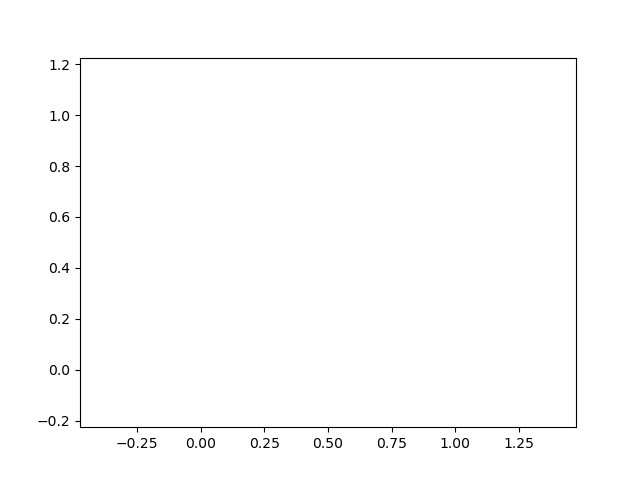

<IPython.core.display.Javascript object>


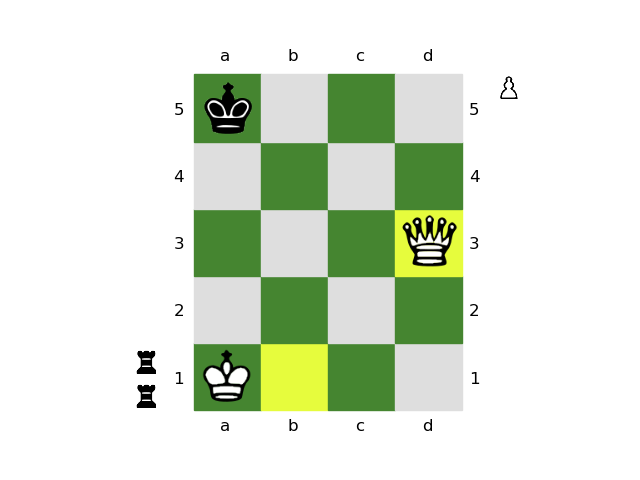

In [53]:
mw = widgets.Text(
            value='',
            placeholder='',
            description='Move:',
            disabled=False
        )
def obradi(widget):
    widget.disabled = True
    b.draw()
    time.sleep(4)
    plt.cla()
    widget.value = ""
    t2.draw()
    widget.disabled = False
    
mw.on_submit(obradi)
display(mw)

In [185]:
i1 = Interface("prvo")

D:\Temp\ipykernel_10404\809723877.py:33: DeprecationWarning: on_submit is deprecated. Instead, set the .continuous_update attribute to False and observe the value changing with: mywidget.observe(callback, 'value').
  self.pw.on_submit(self.obradi)


Checkbox(value=False, description='Run game "prvo"', indent=False)

Dropdown(description='Dubina:', index=4, options=('1', '2', '3', '4', '5', '6', '7', '8'), value='5')

Text(value='RQKR PPPP .... pppp rqkr', description='Start. pos:', placeholder='RQKR PPPP .... pppp rqkr')

Text(value='', description='Move:', placeholder='example: a2a3')

Your move:a2a3


TypeError: _moveR() missing 1 required positional argument: 'end'

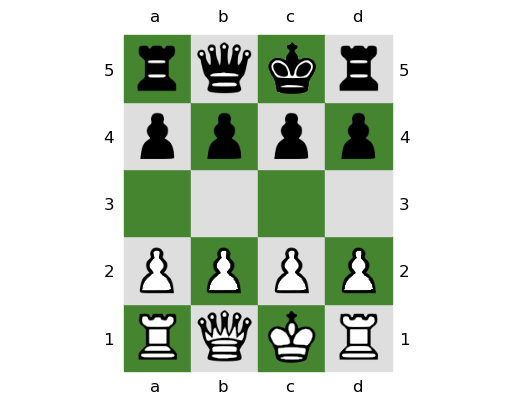

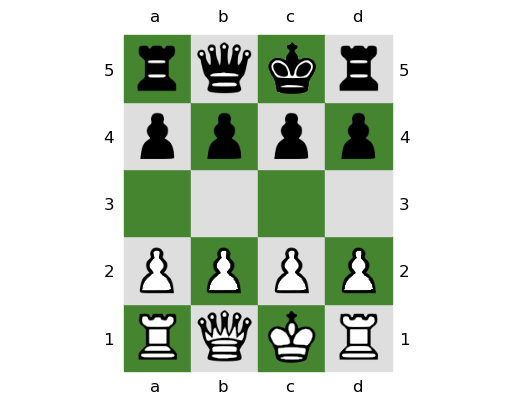

In [157]:
i1.run()

In [129]:
def _Interface():
  if(run == False): return

  #initialization
  b = Board(startingPosition)
  b.toMove = "white"
  refresh(b)
  print(b)

  # FIRST MOVE:
  move = input("Your move: ")
  if(move == "exit" or move == "surrender"): 
    print("BLACK WINS!")
    return
  if(not legalString(b, move)):
    while(not legalString(b, move)):
      print("Invalid input! Try again.")
      move = input("Your move: ")
      if(move == "exit" or move == "surrender"): 
        print("BLACK WINS!")
        return

  move = genMove(move)
  playerState = makeMove(b, move)
  print(playerState)

  #checking for game end
  if(len(nextStates(playerState)) == 0):
      if(playerState.bic):
        print("WHITE WINS!")
      else:
        print("STALEMATE!")

  print("AI calculating...")
  AIState = MinMaxBlack(playerState, depth, hMain)
  print(AIState)

  #checking for game end
  if(len(nextStates(AIState)) == 0):
      if(AIState.wic):
        print("BLACK WINS!")
      else:
        print("STALEMATE!")

  # MAIN GAME LOOP:
  while(True):
    move = input("Your move: ")
    if(move == "exit" or move == "surrender"): 
      print("BLACK WINS!")
      return
    if(not legalString(AIState, move)):
      while(not legalString(AIState, move)):
        print("Invalid input! Try again.")
        move = input("Your move: ")
        if(move == "exit" or move == "surrender"): 
          print("BLACK WINS!")
          return
    move = genMove(move)
    playerState = makeMove(AIState, move)

    clear_output()
    print(playerState)

    #checking for game end
    if(len(nextStates(playerState)) == 0):
      if(playerState.bic):
        print("WHITE WINS!")
        break
      else:
        print("STALEMATE!")
        break 

    print("AI calculating...")
    AIState = MinMaxBlack(playerState, depth, hMain)
    print(AIState)

    #checking for game end
    if(len(nextStates(AIState)) == 0):
      if(AIState.wic):
        print("BLACK WINS!")
        break
      else:
        print("STALEMATE!")
        break

  return

- This next version of the interface has a functionality to control the move timer for the AI.
- The iterative depth version called "MinMaxBlackIterative" of the min-max algorithm is used for generating the response from AI to the given positions. The "moveTime" is passed as the argument for limiting calculation time.

In [172]:
def InterfaceTime():
  if(run == False): return

  #initialization
  b = Board(startingPosition)
  b.toMove = "white"
  refresh(b)
  print(b)

  #first move
  move = input("Your move: ")
  if(move == "exit" or move == "surrender"): 
    print("BLACK WINS!")
    return
  if(not legalString(b, move)):
    while(not legalString(b, move)):
      print("Invalid input! Try again.")
      move = input("Your move: ")
      if(move == "exit" or move == "surrender"): 
        print("BLACK WINS!")
        return

  move = genMove(move)
  playerState = makeMove(b, move)
  print(playerState)

  #checking for game end
  if(len(nextStates(playerState)) == 0):
      if(playerState.bic):
        print("WHITE WINS!")
      else:
        print("STALEMATE!")

  print("AI calculating...")
  AIState = MinMaxBlackIterative(playerState, hMain, moveTime)
  print(AIState)

  #checking for game end
  if(len(nextStates(AIState)) == 0):
      if(AIState.wic):
        print("BLACK WINS!")
      else:
        print("STALEMATE!")

  #main game loop
  while(True):
    move = input("Your move: ")
    if(move == "exit" or move == "surrender"): 
      print("BLACK WINS!")
      return
    if(not legalString(AIState, move)):
      while(not legalString(AIState, move)):
        print("Invalid input! Try again.")
        move = input("Your move: ")
        if(move == "exit" or move == "surrender"): 
          print("BLACK WINS!")
          return

    move = genMove(move)
    playerState = makeMove(AIState, move)

    clear_output()
    print(playerState)

    #checking for game end
    if(len(nextStates(playerState)) == 0):
      if(playerState.bic):
        print("WHITE WINS!")
        break
      else:
        print("STALEMATE!")
        break 

    print("AI calculating...")
    AIState = MinMaxBlackIterative(playerState, hMain, moveTime)
    print(AIState)

    #checking for game end
    if(len(nextStates(AIState)) == 0):
      if(AIState.wic):
        print("BLACK WINS!")
        break
      else:
        print("STALEMATE!")
        break

  return

# Vježbe matiranja
Provjera je li umjetna inteligencija sposobna pretvoriti neke klasične završnice u šah-mat.<br>
Čitatelj se poziva na pokušaj obrane od napada crnog. Preporučena dubina za ove primjere je 5. S manje od toga AI će biti *slijep* u nekim primjerima. Veća dubina zahtjeva više resursa i mogla bi uzrokovati neželjeno čekanje. 

In [173]:
# CHECKMATING WITH A QUEEN
run = False
depth = 5
startingPosition = ("q... .k.. .... .... ..K.")
Interface()

In [174]:
# CHECKMATING WITH A ROOK
run = False
depth = 5
startingPosition = ("k... .r.. .... .... ..K.")
Interface()

U idućem primjeru je pozicija u kojoj bi neoprezan igrač crnih mogao propustiti priliku za pobjedu. Ako je AI dovoljno pametan će primijetiti da mora prije pomaka pijuna zaštititi polje promoviranja kraljem. Dubina pretraživanja manja od 5 nije dovoljna.

In [188]:
# CHECKMATING WITH A PAWN
run = True
depth = 6
startingPosition = (".... .... ..p. K.k. ....")
Interface()

[]
  +---+---+---+---+
5 |   |   |   |   |
  +---+---+---+---+
4 |   | q |   |   |
  +---+---+---+---+
3 |   |   |   |   |
  +---+---+---+---+
2 | ₭ |   |   | k |
  +---+---+---+---+
1 |   |   |   |   |
  +---+---+---+---+
    a   b   c   d
[]

AI calculating...
AI evaluates:  -740
[]
  +---+---+---+---+
5 |   |   |   |   |
  +---+---+---+---+
4 |   | q |   |   |
  +---+---+---+---+
3 |   |   |   |   |
  +---+---+---+---+
2 | ₭ |   |   |   |
  +---+---+---+---+
1 |   |   | k |   |
  +---+---+---+---+
    a   b   c   d
[]

Your move: exit
BLACK WINS!


#Player vs AI rules
- **MANUAL:**
- To run the game set the "run" parameter to True and to prevent the game from running set it to False. Then run the cell.
- The "moveTime" parameter describes the maximum time in seconds the AI can use to generate a move. 
- The more time the AI has to think the better the move it makes will be. After it makes a move it will print out how many moves ahead it checked out.
- The "startingPostion" can be changed if a player wishes to start from a custom one
  - See notes in **BOARD CREATION** section for info on piece and board representation.
- Above the board there is a list of captured white pieces. Below the board the same for black.
- When prompted with the "Your move:" box, enter a string representing Your move following these rules:
  - Only 4 characters are allowed.
  - The first two characters represent the coordinates of the piece to move.
  - The last two characters represent the target location for the moved piece.
  - Example: "a2a3" moves the piece on a2 to a3.
- After making a move the board state will be shown at the top and the AI will generate its response and print it out.
- To exit the game type "exit" or "surrender" instead of the move.

# Igra

## Vremenski ograničena

In [177]:
run = False
moveTime = 5
startingPosition = "RQKR PPPP .... pppp rqkr"

InterfaceTime()

## Fiksne dubine


In [178]:
run = False
depth = 4
startingPosition = "RQKR PPPP .... pppp rqkr"

Interface()